# T2 Strategies

These are based on original Titan strategies with a different parameter structure which makes it easier to use in distributed celery systems.

## Parameters

- strategy: file name of strategy in t2 module
- type: 't2'
- default: parameters used by the base strategy class
- limits: parameters dealing with money management
- custom: parameters used by the specific strategy
- portfolio: set the name key to a string to track different sets of api keys (temporary ad hoc way to accomplish this)

## PortfolioBase class

I am using this as the base class of t2 strategies going forward. It will handle money management (the limits parameters) in the future. It will also have access to other exchanges and other strategies in play for more dynamic money management. I am also semi using this class to non-destructively refactor the BaseStrategy class and possibly replace it altogether.

## Examples

- The first example is a working dual moving average strategy.
- The second example runs all the current working indicators without simulated any trading. The results get stored in the Backtest table. Those are output below.

## Running

Install Docker.

- Run `docker-compose up` to bring up the network with these images
    - jupyter
    - redis
    - timescale
    - all workers
- Go to http://0.0.0.0:8888/lab

In [34]:
from os import getcwd
from kryptobot.portfolio.manager import Manager

config = getcwd() + '/config.json'
manager = Manager(config=config)

params = {
    'strategy': 'kitchen_sink_analysis',
    'type': 't2',
    'default': {
        'interval': '5m',
        'exchange': 'bittrex',
        'base_currency': 'ZEC',
        'quote_currency': 'BTC',
        'is_simulated': True,
    },
    'limits': {
        'capital_base': 1000,
        'order_quantity': 100,
        'position_limit': 1000,
        'profit_target_percentage': 1.2,
        'fixed_stoploss_percentage': .95,
        'trailing_stoploss_percentage': .90
    },
    'custom': {
        'period': 12,
#         Moving Average Envelope
        'env_percentage': 10,
#         2 params for Price Channels
        'upper_percent': 10,
        'lower_percent': 10
    },
    'portfolio': {
        'name': 'default'
    }
}

strategy_id = manager.run_strategy(params)
print('strategy_id', strategy_id)

strategy_id {'strategy_id': 76, 'celery_id': 'ab00c5c6-15a1-4dcb-8671-6e5bf4767f52'}


In [6]:
from os import getcwd
from kryptobot.portfolio.manager import Manager

config = getcwd() + '/config.json'
manager = Manager(config=config)

params = {
    'strategy': 'dual_simple_moving_average',
    'type': 't2',
    'default': {
        'interval': '5m',
        'exchange': 'bittrex',
        'base_currency': 'LTC',
        'quote_currency': 'BTC',
        'is_simulated': True,
#         'start': '2017-06-15',
#         'end': '2018-06-15',
    },
    'limits': {
        'capital_base': 1000,
        'order_quantity': 100,
        'position_limit': 1000,
        'profit_target_percentage': 1.05,
        'fixed_stoploss_percentage': .96,
        'trailing_stoploss_percentage': .98
    },
    'custom': {
        'short_window': 12,
        'long_window': 60,
#         'short_window': 12,
#         'long_window': 120,
    },
    'portfolio': {
        'name': 'default'
    }
}

details = manager.run_strategy(params)
print(details)

{'strategy_id': 78, 'celery_id': '1573a621-97db-4955-8e62-c7c855b03ea7'}


In [7]:
# TODO: This does not work for stopping it
manager.stop_strategy(78)

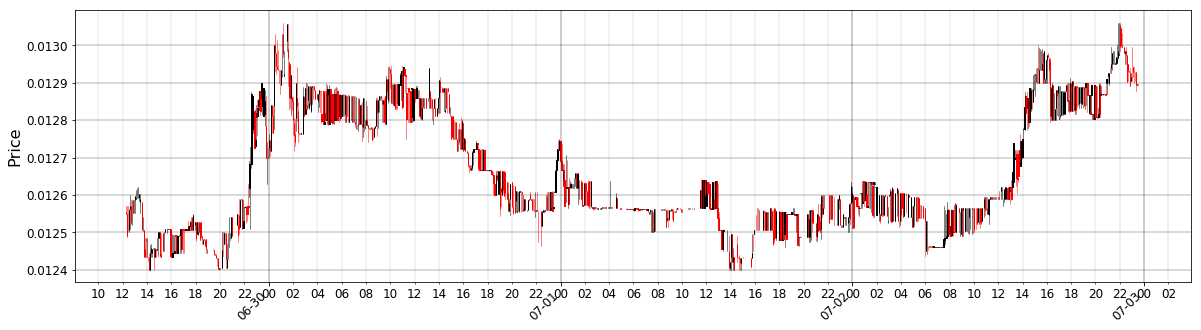

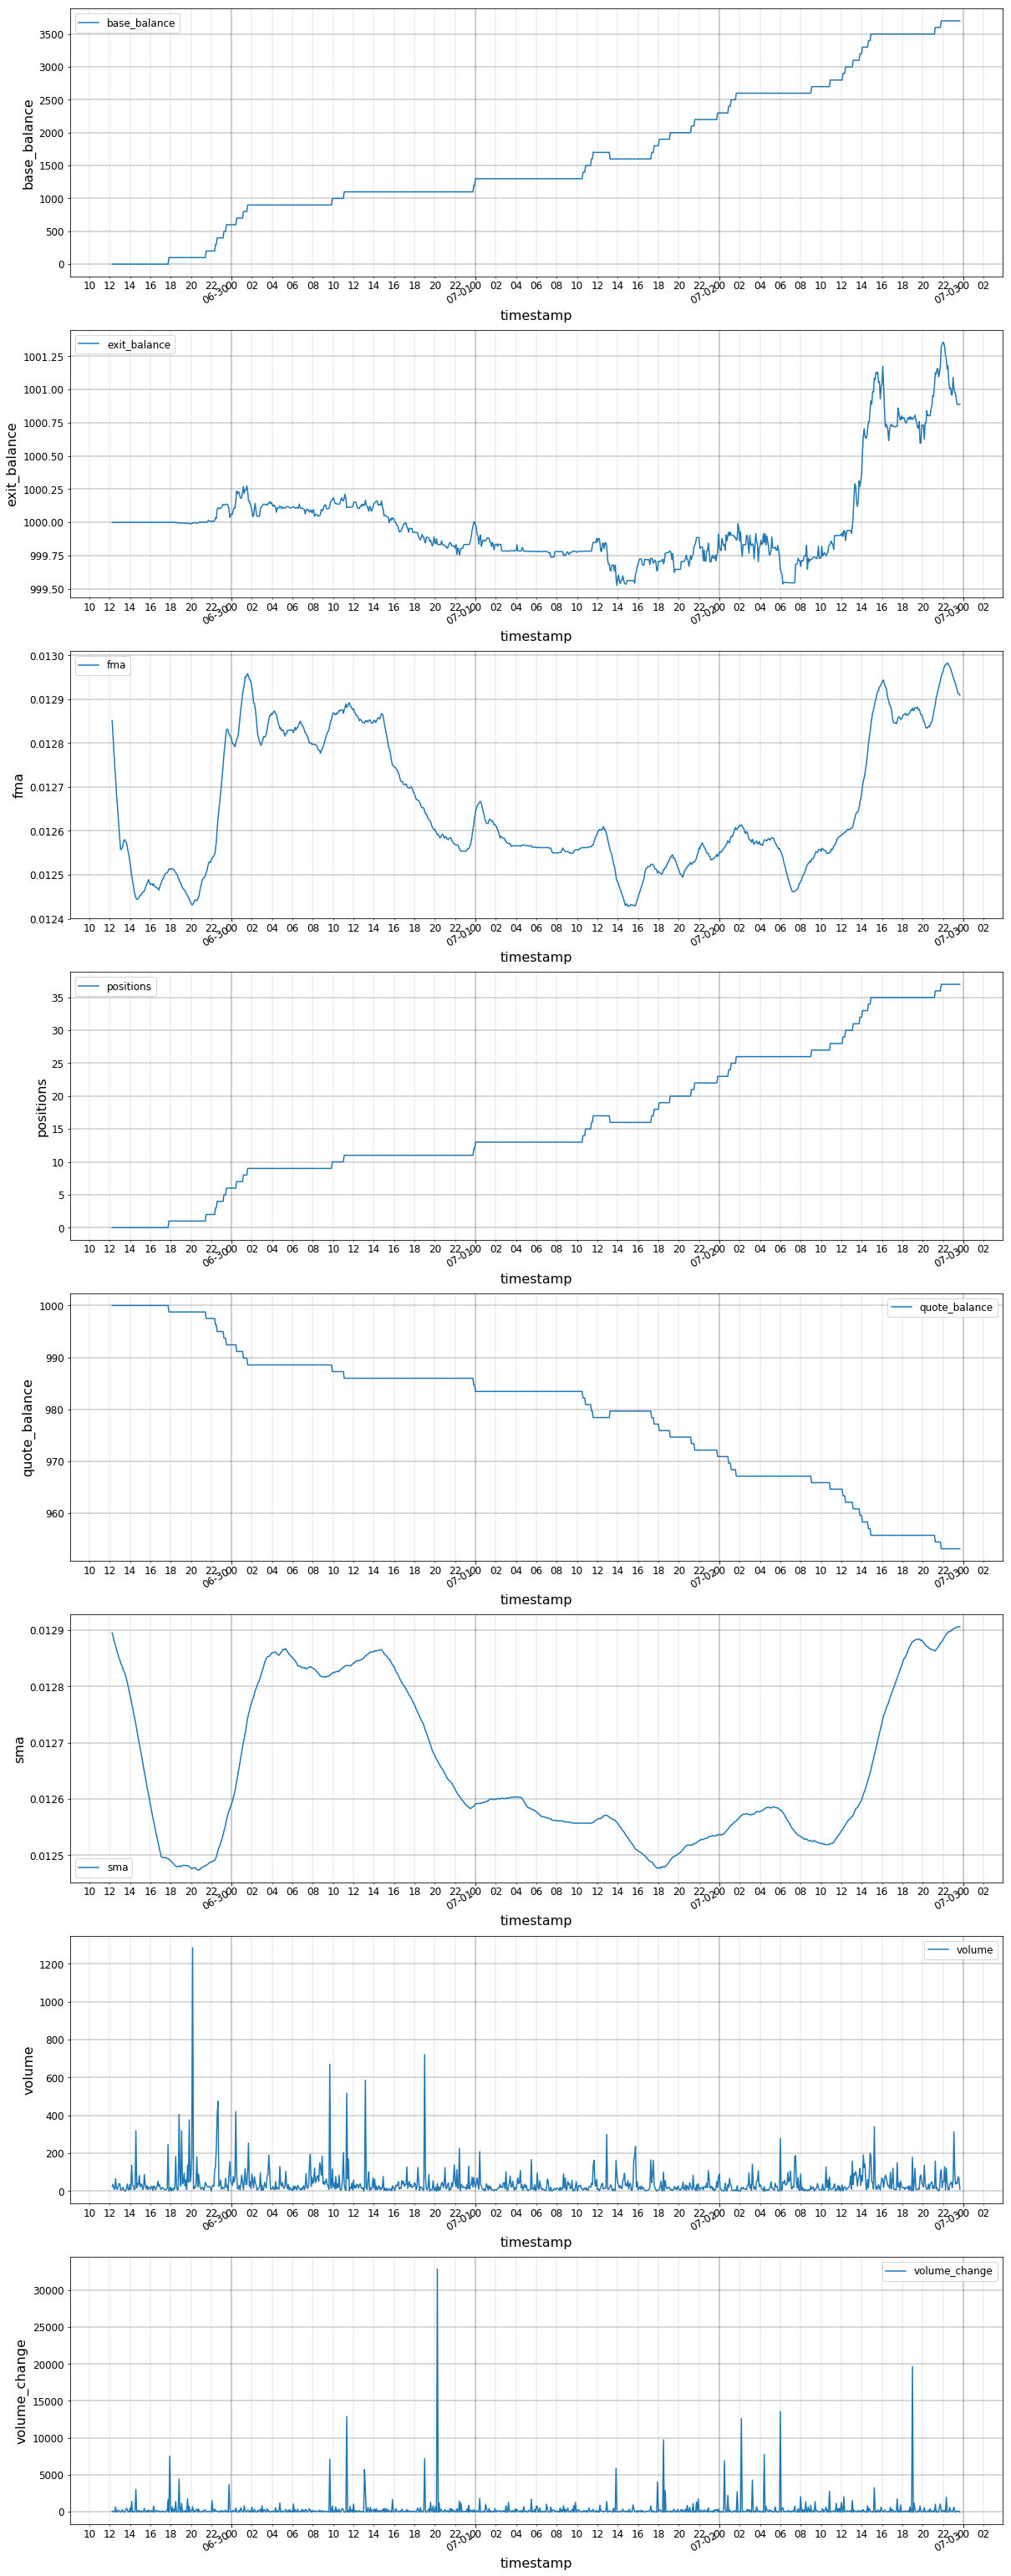

In [38]:
from os import getcwd
from kryptobot.portfolio.manager import Manager

config = getcwd() + '/config.json'
manager = Manager(config=config)
%matplotlib inline

run_keys = manager.get_strategy_run_keys(78)
run_key = run_keys[-1]

# Dataframe
# results = manager.get_results(run_key)
# results.tail(100)

# Candlestick Data
manager.show_candle_chart(run_key)

# Indicator Data
manager.show_indicator_charts(run_key)

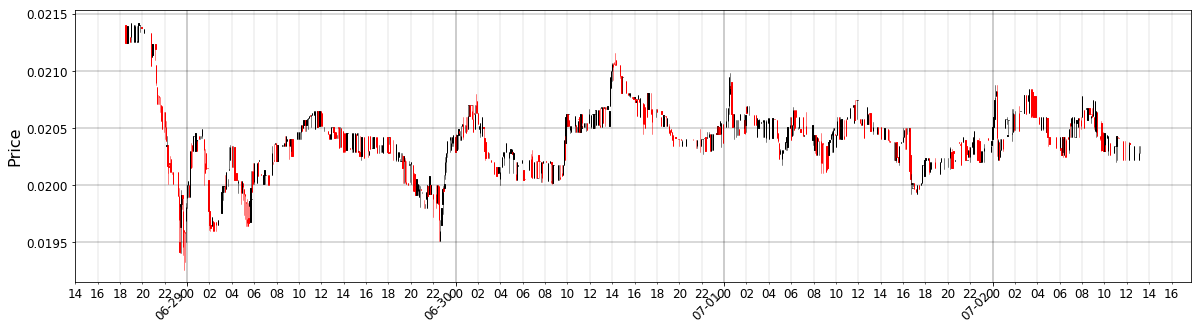

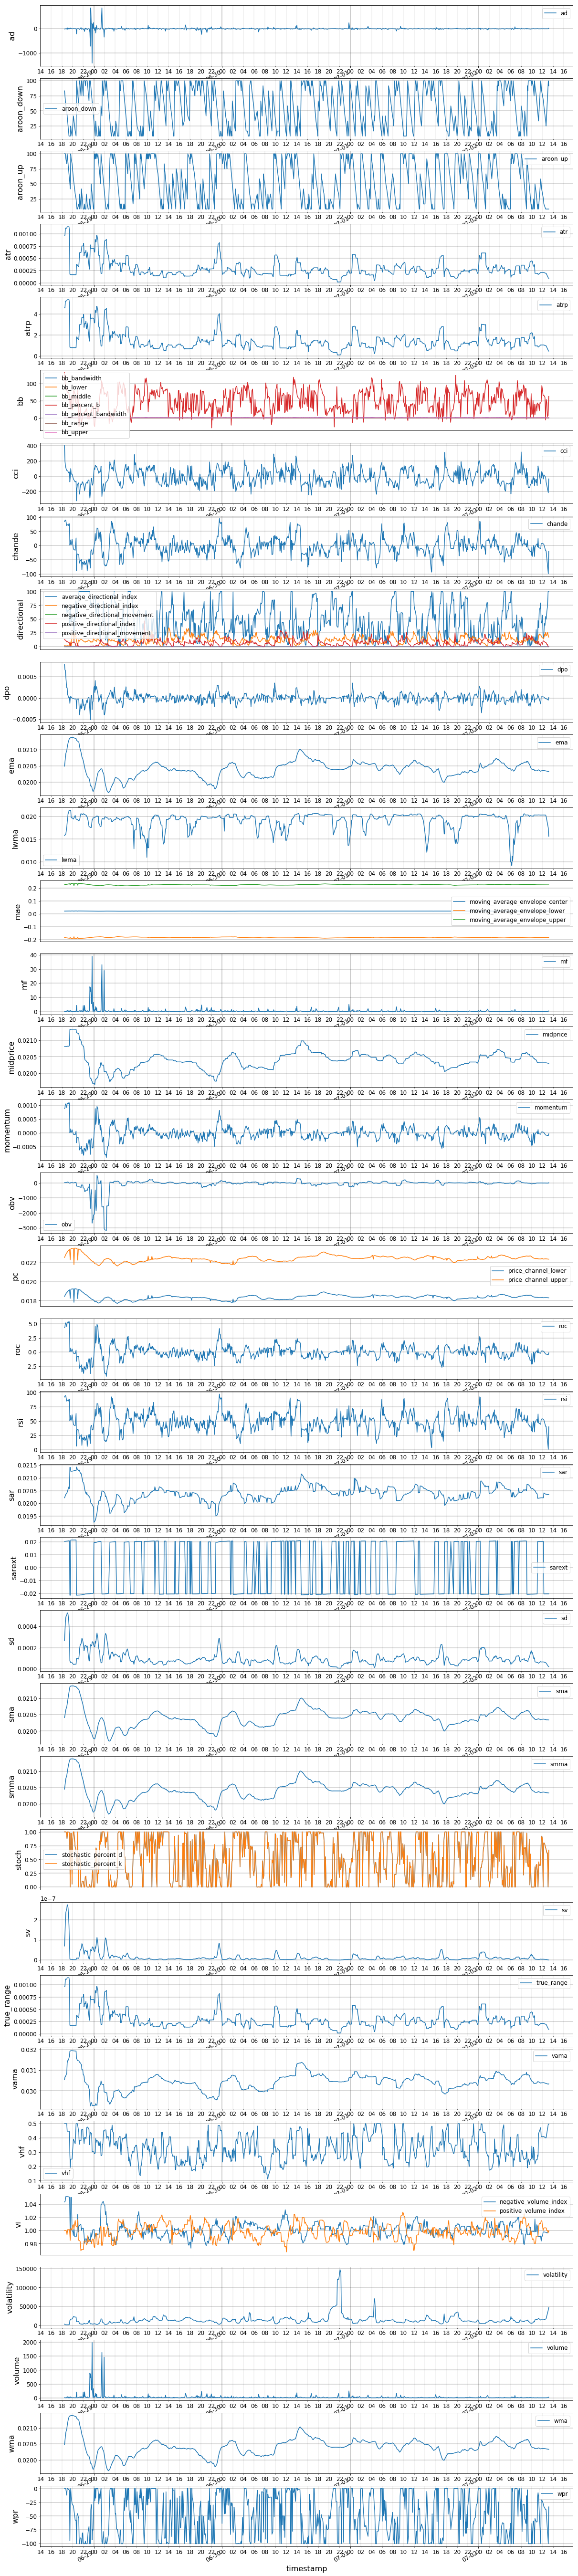

In [2]:
from os import getcwd
from kryptobot.portfolio.manager import Manager

config = getcwd() + '/config.json'
manager = Manager(config=config)
%matplotlib inline

run_key = 'e2bd99eb-e6c1-42bb-8ac2-0ae69452d715'
manager.show_candle_chart(run_key)
manager.show_indicator_charts(run_key)

In [ ]:
import talib
help(talib.APO)